# Code Abstract
This implementation is based on the articles from Andersen et al., Repeated quantum error detection in a surface code, https://www.nature.com/articles/s41567-020-0920-y

The logical Qubit representation for a \[\[4, 1, 2\]\] stabilizer code is given by the logical operators:
$ {\left|{0}\right\rangle}_{L} = \frac{1}{\sqrt{2}}\Bigl({\left|{0000}\right\rangle}+{\left|{1111}\right\rangle}\Bigr) $
$ {\left|{1}\right\rangle}_{L} = \frac{1}{\sqrt{2}}\Bigl({\left|{0101}\right\rangle}+{\left|{1010}\right\rangle}\Bigr) $


## Code imports

In [507]:
import random
import qiskit
import qiskit.tools.parallel

qiskit.__qiskit_version__

from qiskit.tools.visualization import plot_histogram
from qiskit.visualization import plot_state_city, plot_bloch_multivector
from qiskit.visualization import plot_state_paulivec, plot_state_hinton
from qiskit.visualization import plot_bloch_vector
from qiskit.visualization import plot_state_qsphere

from qiskit.providers.ibmq import least_busy

import qiskit.quantum_info as qi

from numpy import *
from qiskit import *
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from qiskit_aer import AerSimulator

## Qubit metadata definition (classes)
The classes are organized as follows:
- **LogicalCircuitDefinition**: Circuit definition for the logical Qubits
- **LogicalQubitDefinition**: Represents the logical Qubit we are creating as defines helper methods to create and maintain the data qubits
- **SurfaceCode**: Helpful method for creating the Surface code circuits
- **ErrorSimulation**: Simulates different type of errors

In [508]:
class LogicalCircuitDefinition:
    pass

class LogicalQubitDefinition:
    def __init__(self, lqc: LogicalCircuitDefinition):
        self.n = lqc.n
        self.m = lqc.m

        self.data_qu = QuantumRegister(lqc.n)
        self.ancilla_qu = AncillaRegister(lqc.m)
        self.classical_bits = ClassicalRegister(lqc.m)

        self.qc = lqc.qc
        self.qc.add_register(self.data_qu)
        self.qc.add_register(self.ancilla_qu)
        self.qc.add_register(self.classical_bits)

        # Put all qubits into ground state
        for j in range(lqc.n):
            self.qc.reset(self.data_qu[j])
        for j in range(lqc.m):
            self.qc.reset(self.ancilla_qu[j])

# Logical Quantum circuit representation
class LogicalCircuitDefinition:
    def __init__(self, d: int):
        self._nbLQubits_0 = 0
        self._nbLQubits_1 = 0

        self.n = d
        self.m = d-1
        self.d = d

        self.lqubits = []
        self.qc = QuantumCircuit()

    # Creates the logical qubit state |0>_L for the given circuit
    def createLogicalQubit_0(self, entangled: bool = True) -> LogicalQubitDefinition:
        lq = LogicalQubitDefinition(self)

        # Entangle all the Bits using Bell's 0000-1111 code base
        if not entangled:
            for d in range(self.n):
                self.qc.reset(lq.data_qu[d])
        else:
            for d in range(self.n):
                if d == 0:
                    self.qc.h(lq.data_qu[d])
                else:
                    self.qc.cx(lq.data_qu[d-1], lq.data_qu[d])

        self.lqubits.append(lq)
        # increase the number of logical qubits in the circuit
        self._nbLQubits_0 += 1
        return lq

    # Creates the logical qubit state |1>_L for the given circuit
    def createLogicalQubit_1(self, entangled = True) -> LogicalQubitDefinition:
        lq = LogicalQubitDefinition(self)

        # Entagles using Bell's basis 0101-1010
        if not entangled:
            for d in range(self.n):
                self.qc.x(lq.data_qu[d])
                self.qc.cx(lq.data_qu[d-1], lq.data_qu[d])
        else:
            for d in range(self.n):
                if d == 0:
                    self.qc.h(lq.data_qu[d])
                else:
                    self.qc.x(lq.data_qu[d])
                    self.qc.cx(lq.data_qu[d-1], lq.data_qu[d])

        self.lqubits.append(lq)
        # increase the number of logical qubits in the circuit
        self._nbLQubits_1 += 1
        return lq

    # Unitary operation on the logical qubit (Hadamard gate)
    def lH(self, lqu: LogicalQubitDefinition):
        for d in range(self.n):
            self.qc.h(lqu.data_qu[d])

    # Unitary operation on the logical qubit (NOT gate)
    def lX(self, lqu: LogicalQubitDefinition):
        for d in range(self.n):
            self.qc.x(lqu.data_qu[d])

    # Unitary operation on the logical qubit (Y gate)
    def lY(self, lqu: LogicalQubitDefinition):
        for d in range(self.n):
            self.qc.y(lqu.data_qu[d])

    # Unitary operation on the logical qubit (Z gate)
    def lZ(self, lqu: LogicalQubitDefinition):
        for d in range(self.n):
            self.qc.z(lqu.data_qu[d])

    def getTotalNumberOfLogicalQubits(self) -> int:
        return self._nbLQubits_1 + self._nbLQubits_0

    def getNumberLogicalZeros(self) -> int:
        return self._nbLQubits_0

    def getNumberLogicalOnes(self) -> int:
        return self._nbLQubits_1

# Surface code definitions
class SurfaceCode:
    def __init__(self, lqc: LogicalCircuitDefinition):
        self.lqc = lqc

    # Creates the bit-flip measurement circuit
    def check4BitFlip(self, lqu: LogicalQubitDefinition):
        self.lqc.qc.barrier()
        # clean the ancilla qubit for error check
        for j in range(self.lqc.m):
            if j % (self.lqc.d / 2) == 0:
                self.lqc.qc.reset(lqu.ancilla_qu[j])
                self.lqc.qc.h(lqu.ancilla_qu[j])

        #self.lqc.qc.barrier()
        ancilla_idxeven: int = 0
        ancilla_idxodd: int = self.lqc.m -1
        for k in range(self.lqc.n):
            if k % (self.lqc.d / 2) == 0:
                self.lqc.qc.cz(lqu.data_qu[k], lqu.ancilla_qu[ancilla_idxeven])
            else:
                self.lqc.qc.cz(lqu.data_qu[k], lqu.ancilla_qu[ancilla_idxodd])

        #self.lqc.qc.barrier()
        for j in range(self.lqc.m):
            if j % (self.lqc.d / 2) == 0:
                self.lqc.qc.h(lqu.ancilla_qu[j])
                self.lqc.qc.measure(lqu.ancilla_qu[j], lqu.classical_bits[j])

    # Creates the phase-flip measurement circuit
    def check4PhaseFlip(self, lqu: LogicalQubitDefinition):

        self.lqc.qc.barrier()
        # clean the ancilla qubit for error check
        for j in range(self.lqc.m):
            if j % (self.lqc.d / 2) != 0 and j > 0:
                self.lqc.qc.reset(lqu.ancilla_qu[j])
                self.lqc.qc.h(lqu.ancilla_qu[j])
        # Hadamard before the read-out
        self.lqc.lH(lqu)

        #self.lqc.qc.barrier()

        ancilla_idx: int = 1
        data_idx: int = 0
        while data_idx < self.lqc.n:
            print(f"Data index[{data_idx}] <-> Ancilla index[{ancilla_idx}]")
            self.lqc.qc.cz(lqu.data_qu[data_idx], lqu.ancilla_qu[ancilla_idx])

            # Middle Pauli Z-gate
            if data_idx % self.lqc.n and data_idx > self.lqc.d:
                ancilla_idx += self.lqc.d

            data_idx += 1

        #self.lqc.qc.barrier()

        # Hadamard before the read.out
        self.lqc.lH(lqu)
        for j in range(self.lqc.m):
            if j % (self.lqc.d / 2) != 0 and j > 0:
                self.lqc.qc.h(lqu.ancilla_qu[j])
                self.lqc.qc.measure(lqu.ancilla_qu[j], lqu.classical_bits[j])

BITFLIP_IDX = 0
PHASEFLIP_IDX = 1
# Error simulation
class ErrorSimulation:
    def __init__(self, lqc: LogicalCircuitDefinition):
        self.l_circuit = lqc
        self.sc = SurfaceCode(lqc)

    def addBitFlipError(self, lqu: LogicalQubitDefinition, at: int = -1):
        if at > self.l_circuit.n:
            at = self.l_circuit.n -1
        else:
            at -= 1

        idx: int = 0
        if at < 0:
            idx = random.randint(0,self.l_circuit.n)
        else:
            idx = at

        self.l_circuit.qc.x(lqu.data_qu[idx])

    def addPhaseFlipError(self, lqu: LogicalQubitDefinition, at: int = -1):
        if at > self.l_circuit.n:
            at = self.l_circuit.n -1
        else:
            at -= 1

        idx: int = 0
        if at < 0:
            idx = random.randint(0,self.l_circuit.n)
        else:
            idx = at

        self.l_circuit.qc.z(lqu.data_qu[idx])

    def generateNoise(self, lqu: LogicalQubitDefinition):
        errtype: int = random.randint(BITFLIP_IDX,PHASEFLIP_IDX)

        if errtype == PHASEFLIP_IDX:
            self.addPhaseFlipError(lqu)
            self.l_circuit.qc.barrier()
            return self.sc.check4PhaseFlip(lqu)
        elif errtype == BITFLIP_IDX:
            self.addBitFlipError(lqu)
            self.l_circuit.qc.barrier()
            return self.sc.check4BitFlip(lqu)

## Simulate different circuits with surface code implemented
This section implements 4 different use cases. The first two simply create the error correction circuit and measure its ancillas for stabilization

### Code examples
#### Global code configuration

In [509]:
from qiskit_aer import QasmSimulator

# [[4,1,2]]
nb_d: int = 4
shots = 1024
entangle_qubits = True
ibmq_simulation = True
simulator = Aer.get_backend('qasm_simulator')
simulator2 = Aer.get_backend('aer_simulator_statevector')
simulator3 = Aer.get_backend('aer_simulator_extended_stabilizer')

Aer.backends()

[AerSimulator('aer_simulator'),
 AerSimulator('aer_simulator_statevector'),
 AerSimulator('aer_simulator_density_matrix'),
 AerSimulator('aer_simulator_stabilizer'),
 AerSimulator('aer_simulator_matrix_product_state'),
 AerSimulator('aer_simulator_extended_stabilizer'),
 AerSimulator('aer_simulator_unitary'),
 AerSimulator('aer_simulator_superop'),
 QasmSimulator('qasm_simulator'),
 StatevectorSimulator('statevector_simulator'),
 UnitarySimulator('unitary_simulator'),
 PulseSimulator('pulse_simulator')]

#### Case 1: Logical bit "0" and "1" circuit


In [510]:
# prepares the logical qubits for the stabilizer code [[4,1,2]]
# this includes 4 qubits, 2 ancilla qubits and 2 classical bits per logical qubits
l_circuit1 = LogicalCircuitDefinition(nb_d)
lq0 = l_circuit1.createLogicalQubit_0(entangle_qubits)
lq1 = l_circuit1.createLogicalQubit_1(entangle_qubits)
l_circuit1.qc.barrier()
print(f"# of logical qubits: {l_circuit1.getTotalNumberOfLogicalQubits()}")
print(f"# of logical 0's: {l_circuit1.getNumberLogicalZeros()}")
print(f"# of logical 1's: {l_circuit1.getNumberLogicalOnes()}")

# State vector representation
qasmSimulator = QasmSimulator()
stv1 = qiskit.quantum_info.Statevector.from_instruction(l_circuit1.qc)
execute(l_circuit1.qc, qasmSimulator)
stv1.draw('latex', prefix='\\left|{\\Phi}\\right\\rangle=')

# of logical qubits: 2
# of logical 0's: 1
# of logical 1's: 1


<IPython.core.display.Latex object>

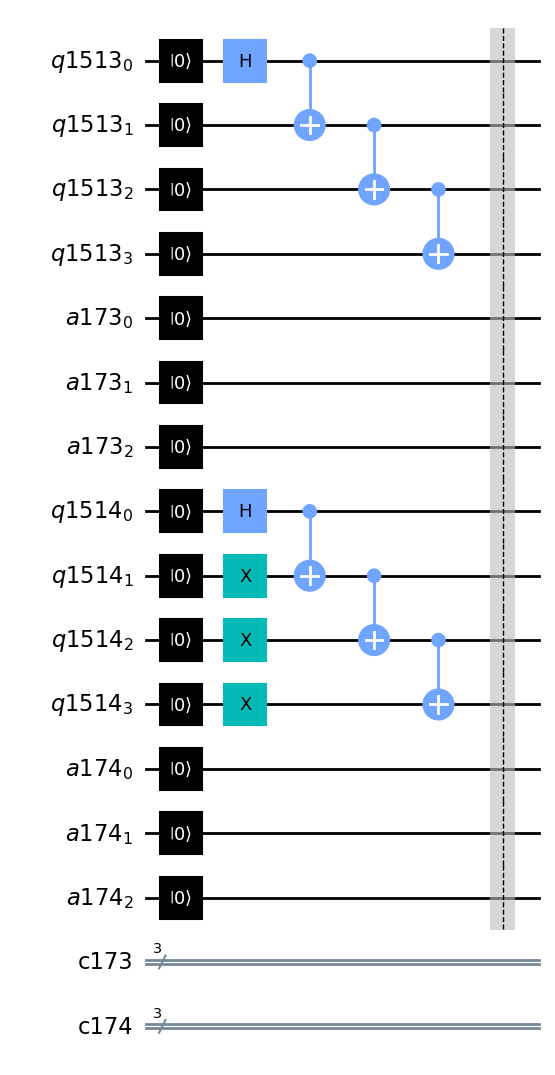

In [511]:
l_circuit1.qc.draw(output='mpl')

#### Case 2: Logical bit "0" with bit-flip error correction implemented


In [512]:
# prepares the logical qubits for the stabilizer code [[4,1,2]]
# this includes 4 qubits, 2 ancilla qubits and 2 classical bits per logical qubits
l_circuit2 = LogicalCircuitDefinition(nb_d)
lq0 = l_circuit2.createLogicalQubit_0(entangle_qubits)
print(f"# of logical qubits: {l_circuit2.getTotalNumberOfLogicalQubits()}")
print(f"# of logical 0's: {l_circuit2.getNumberLogicalZeros()}")
print(f"# of logical 1's: {l_circuit2.getNumberLogicalOnes()}")

# State vector representation
stv2 = qiskit.quantum_info.Statevector.from_instruction(l_circuit2.qc)
execute(l_circuit2.qc, qasmSimulator)
stv2.draw('latex', prefix='\\left|{\\Phi}\\right\\rangle=')

# of logical qubits: 1
# of logical 0's: 1
# of logical 1's: 0


<IPython.core.display.Latex object>

Data index[0] <-> Ancilla index[1]
Data index[1] <-> Ancilla index[1]
Data index[2] <-> Ancilla index[1]
Data index[3] <-> Ancilla index[1]


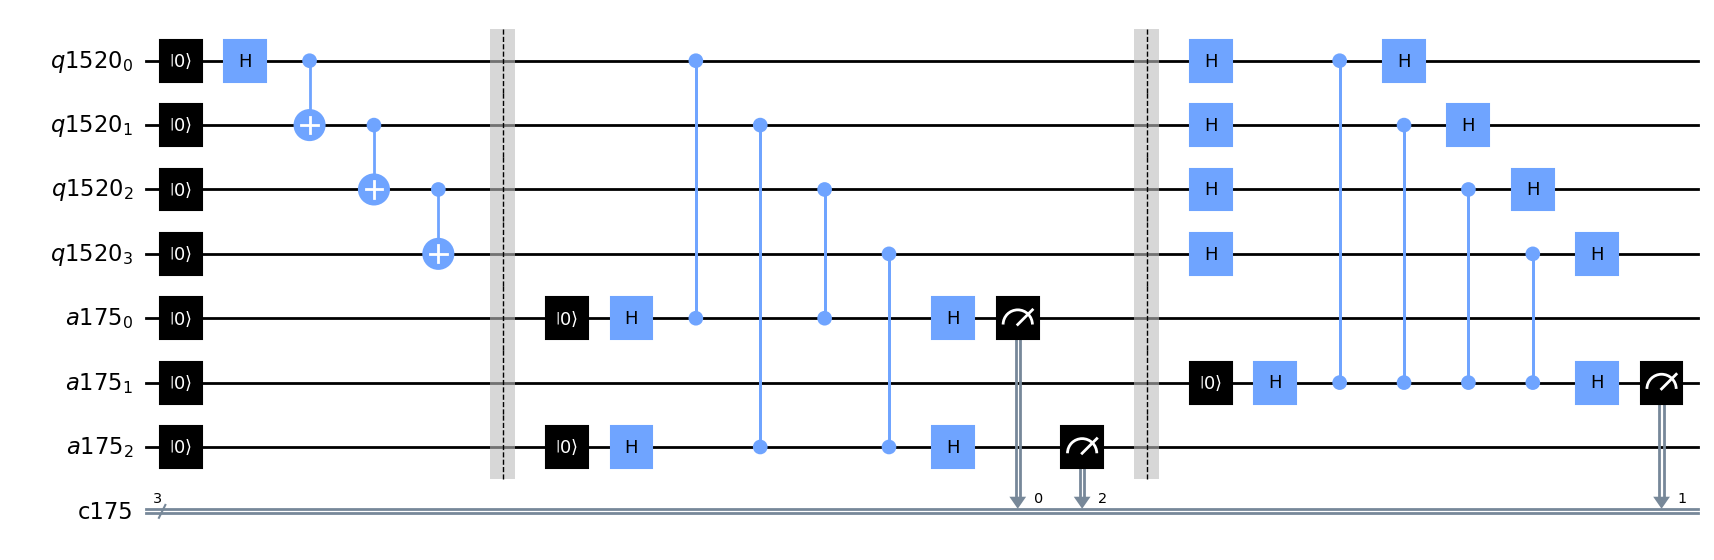

In [513]:
sc = SurfaceCode(l_circuit2)
sc.check4BitFlip(lq0)
sc.check4PhaseFlip(lq0)

l_circuit2.qc.draw(output='mpl')

##### Plot the read-out without any errors

###### Theoritical result should have the stabilizer code defined as: 000


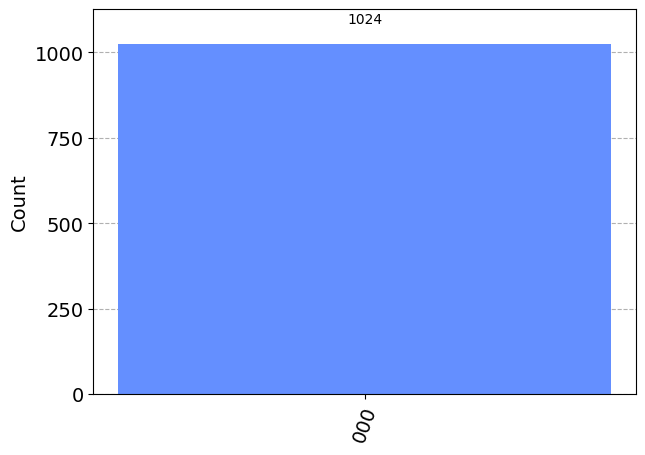

In [514]:
result = execute(l_circuit2.qc, backend=simulator, shots=shots).result()
plot_histogram(result.get_counts(l_circuit2.qc))

#### Case 3: Add a bit-flip error to Logical bit "0" at the second data qubit

In [515]:
# prepares the logical qubits for the stabilizer code [[4,1,2]]
# this includes 4 qubits, 2 ancilla qubits and 2 classical bits per logical qubits
l_circuit3 = LogicalCircuitDefinition(nb_d)
lq0 = l_circuit3.createLogicalQubit_0(entangle_qubits)
print(f"# of logical qubits: {l_circuit3.getTotalNumberOfLogicalQubits()}")
print(f"# of logical 0's: {l_circuit3.getNumberLogicalZeros()}")
print(f"# of logical 1's: {l_circuit3.getNumberLogicalOnes()}")

# State vector representation
stv3 = qiskit.quantum_info.Statevector.from_instruction(l_circuit3.qc)
execute(l_circuit3.qc, qasmSimulator)
stv3.draw('latex', prefix='\\left|{\\Phi}\\right\\rangle=')

# of logical qubits: 1
# of logical 0's: 1
# of logical 1's: 0


<IPython.core.display.Latex object>

##### Add a Z-basis error code to data qubit 2

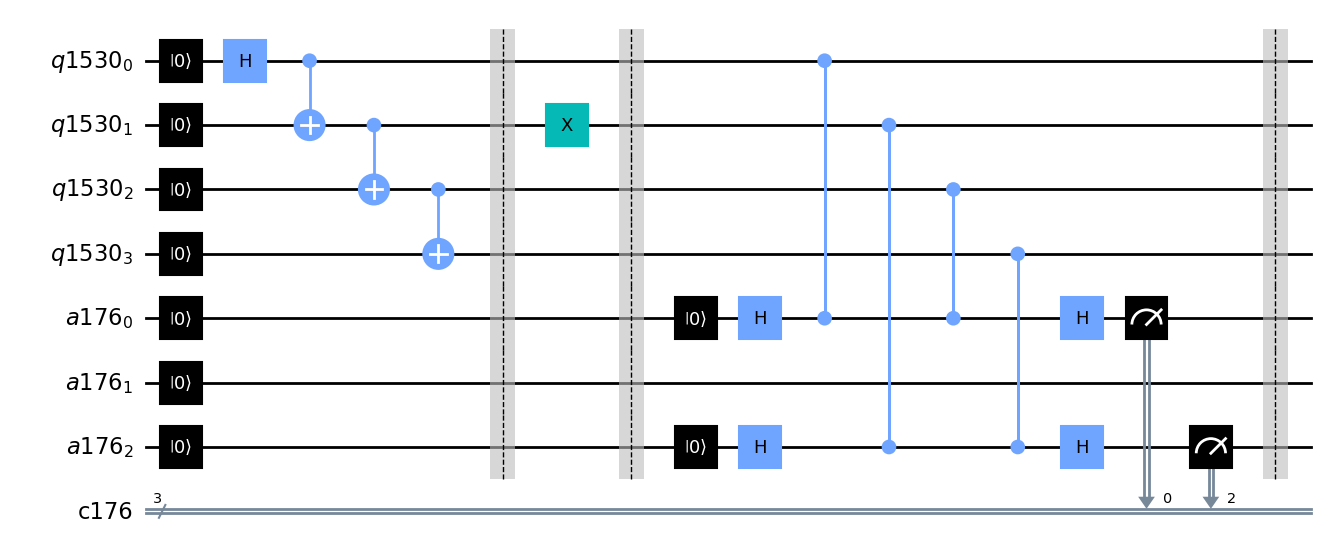

In [516]:
l_circuit3.qc.barrier()

## work the error for data qubit 2
errSimul = ErrorSimulation(l_circuit3)
errSimul.addBitFlipError(lq0, at=2)
errSimul.sc.check4BitFlip(lq0)

l_circuit3.qc.barrier()
l_circuit3.qc.draw(output='mpl')

###### Theoritical result should have the stabilizer code defined as: 100


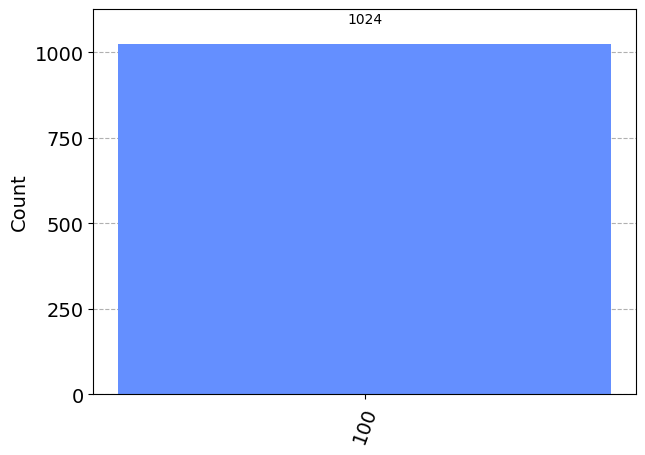

In [517]:
result = execute(l_circuit3.qc, backend=simulator, shots=shots).result()
plot_histogram(result.get_counts(l_circuit3.qc))

#### Case 4: Add a phase-flip error to Logical bit "1" at the third data qubit

In [518]:
# prepares the logical qubits for the stabilizer code [[4,1,2]]
# this includes 4 qubits, 2 ancilla qubits and 2 classical bits per logical qubits
l_circuit4 = LogicalCircuitDefinition(nb_d)
lq1 = l_circuit4.createLogicalQubit_1(entangle_qubits)
print(f"# of logical qubits: {l_circuit4.getTotalNumberOfLogicalQubits()}")
print(f"# of logical 0's: {l_circuit4.getNumberLogicalZeros()}")
print(f"# of logical 1's: {l_circuit4.getNumberLogicalOnes()}")

# State vector representation
stv4 = qiskit.quantum_info.Statevector.from_instruction(l_circuit4.qc)
execute(l_circuit4.qc, qasmSimulator)
stv4.draw('latex', prefix='\\left|{\\Phi}\\right\\rangle=')

# of logical qubits: 1
# of logical 0's: 0
# of logical 1's: 1


<IPython.core.display.Latex object>

Data index[0] <-> Ancilla index[1]
Data index[1] <-> Ancilla index[1]
Data index[2] <-> Ancilla index[1]
Data index[3] <-> Ancilla index[1]


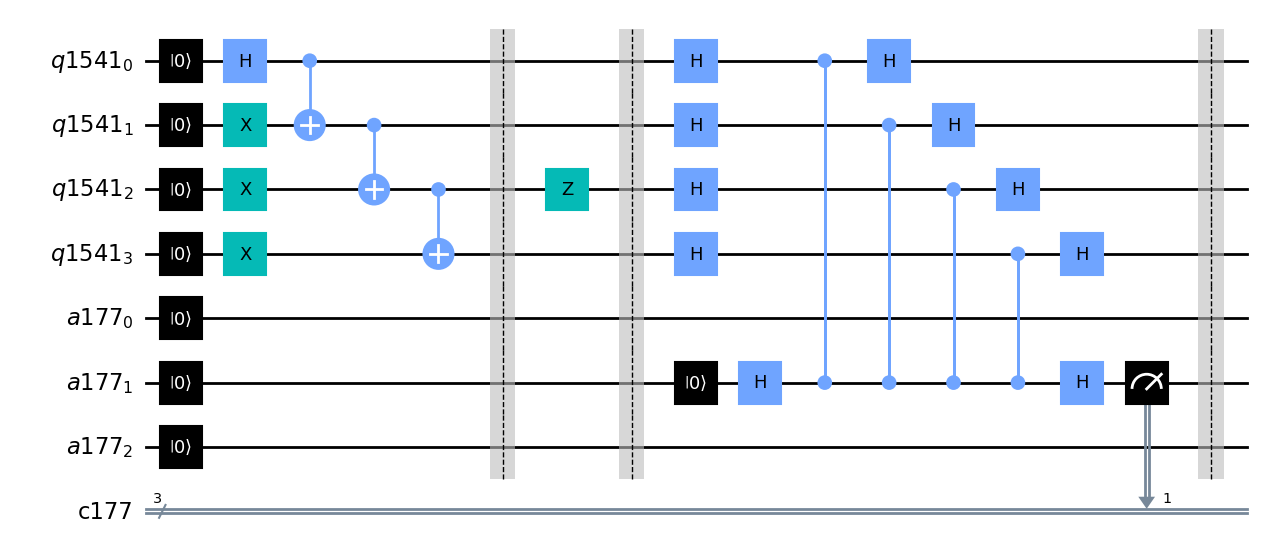

In [519]:
l_circuit4.qc.barrier()

## work the error for data qubit 2
errSimul = ErrorSimulation(l_circuit4)
errSimul.addPhaseFlipError(lq1, at=3)
errSimul.sc.check4PhaseFlip(lq1)

l_circuit4.qc.barrier()
l_circuit4.qc.draw(output='mpl')

###### Theoritical result should have the stabilizer code defined as: 010

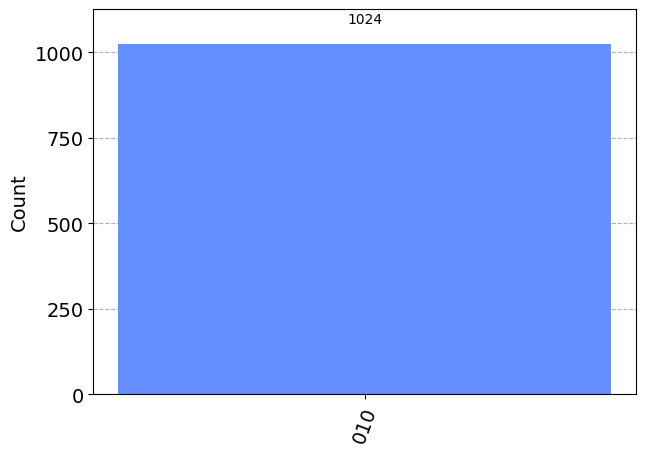

In [520]:
result = execute(l_circuit4.qc, backend=simulator, shots=shots).result()
plot_histogram(result.get_counts(l_circuit4.qc))

#### Case 5: Add both a bit-flip and phase-flip error to Logical bit "0"

In [521]:
# prepares the logical qubits for the stabilizer code [[4,1,2]]
# this includes 4 qubits, 2 ancilla qubits and 2 classical bits per logical qubits
l_circuit5 = LogicalCircuitDefinition(nb_d)
lq0 = l_circuit5.createLogicalQubit_0(entangle_qubits)
print(f"# of logical qubits: {l_circuit5.getTotalNumberOfLogicalQubits()}")
print(f"# of logical 0's: {l_circuit5.getNumberLogicalZeros()}")
print(f"# of logical 1's: {l_circuit5.getNumberLogicalOnes()}")

# State vector representation
stv5 = qiskit.quantum_info.Statevector.from_instruction(l_circuit5.qc)
execute(l_circuit5.qc, qasmSimulator)
stv5.draw('latex', prefix='\\left|{\\Phi}\\right\\rangle=')

# of logical qubits: 1
# of logical 0's: 1
# of logical 1's: 0


<IPython.core.display.Latex object>

Data index[0] <-> Ancilla index[1]
Data index[1] <-> Ancilla index[1]
Data index[2] <-> Ancilla index[1]
Data index[3] <-> Ancilla index[1]


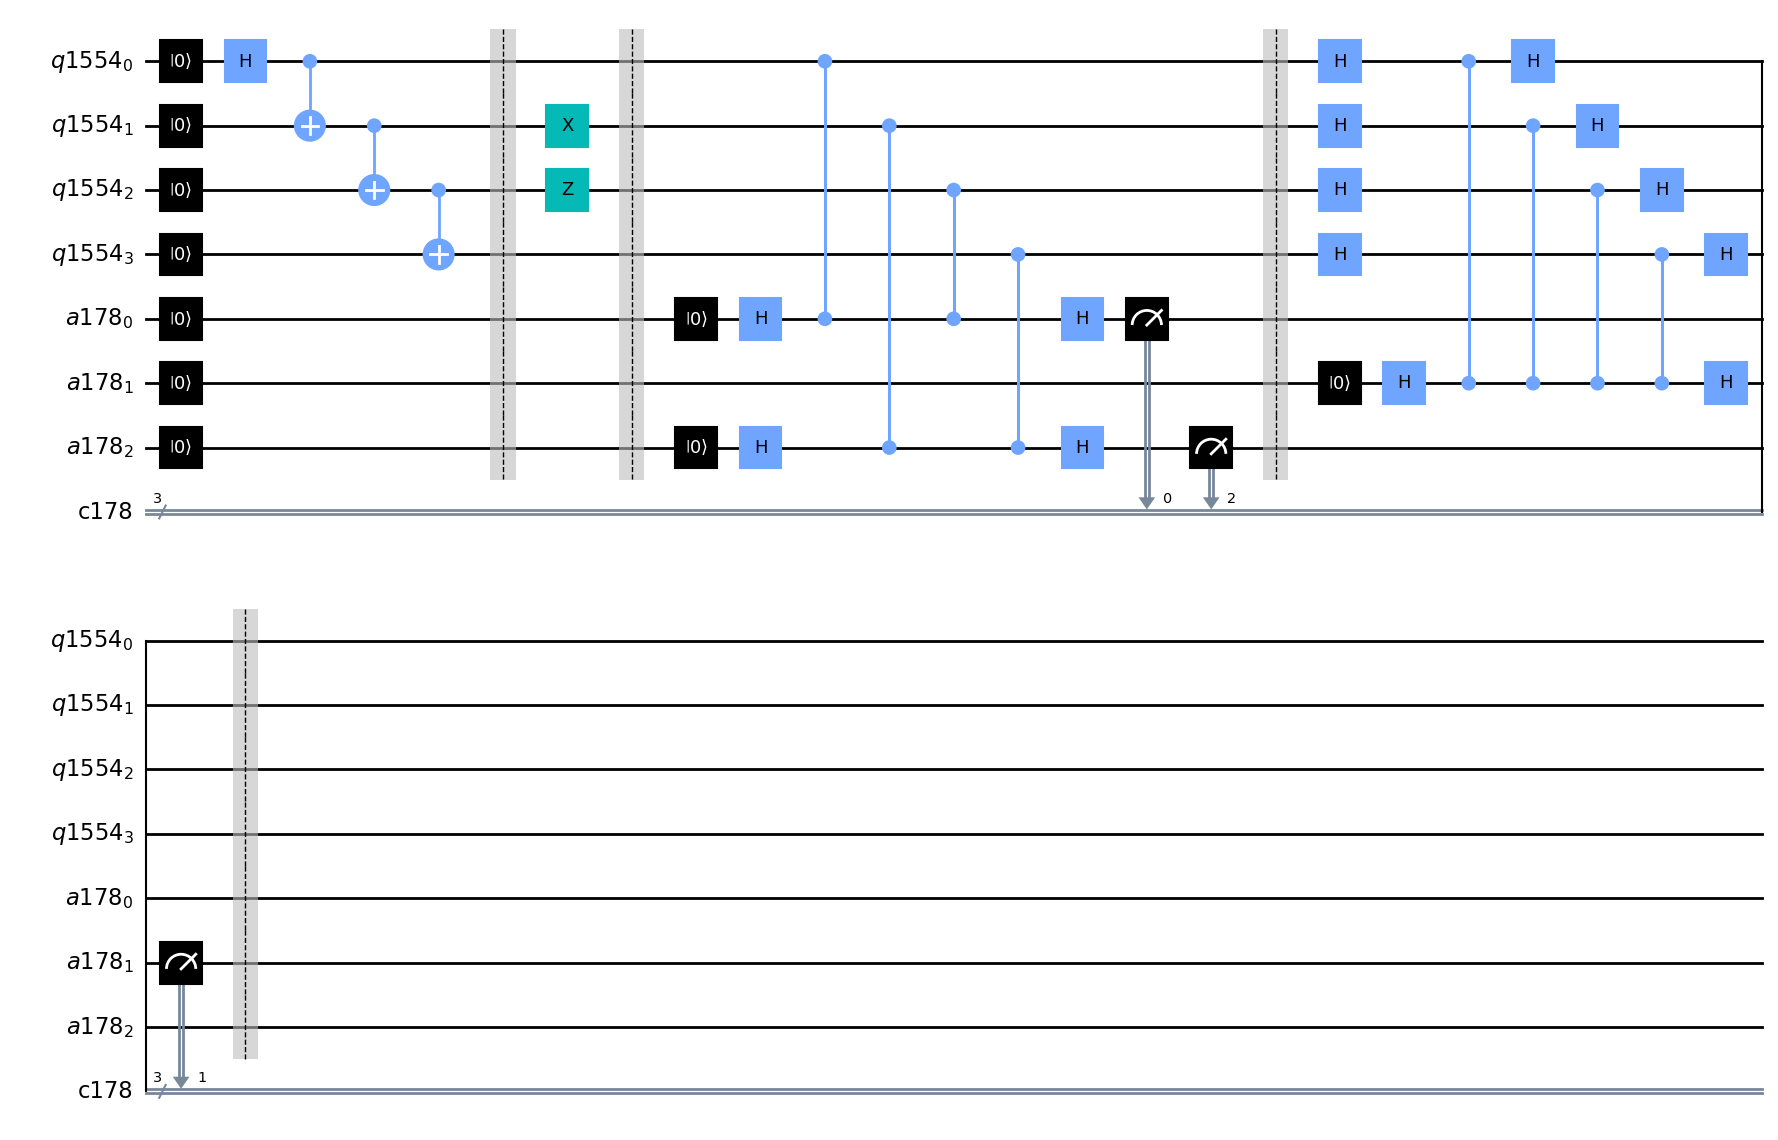

In [522]:
l_circuit5.qc.barrier()
## add a bit-flip error at data qubit 2 and phase qubit error at data qubit 3
errSimul = ErrorSimulation(l_circuit5)
errSimul.addBitFlipError(lq0, at=2)
errSimul.addPhaseFlipError(lq0, at=3)
errSimul.sc.check4BitFlip(lq0)
errSimul.sc.check4PhaseFlip(lq0)

l_circuit5.qc.barrier()
l_circuit5.qc.draw(output='mpl')

###### Theoritical result should have the stabilizer code defined as: 110


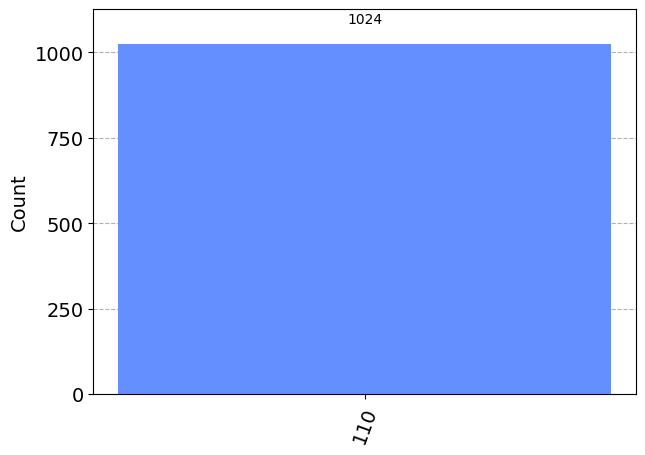

In [523]:
result = execute(l_circuit5.qc, backend=simulator, shots=shots).result()
plot_histogram(result.get_counts(l_circuit5.qc))

In [524]:
backend = BasicAer.get_backend('statevector_simulator') # the device to run on
result = backend.run(transpile(l_circuit5.qc, backend)).result()
psi  = result.get_statevector(l_circuit5.qc)

In [525]:
#plot_state_city(psi)

### Simulation under real Quantum systems: IBM Quantum systems

In [526]:
from qiskit.tools.monitor import job_monitor

provider = None
ibmq_backend = None
if ibmq_simulation:
    IBMQ.load_account()
    provider = IBMQ.get_provider(hub='ibm-q')
    ibmq_backend = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= (2*nb_d -1) and not x.configuration().simulator and x.status().operational==True))
    print(f"least busy backend: {ibmq_backend}")

ibmqfactory.load_account:WARNING:2023-04-29 22:11:46,655: Credentials are already in use. The existing account in the session will be replaced.


least busy backend: ibm_nairobi


In [ ]:
ibmq_job = None
if ibmq_simulation:
    transpiled_dj_circuit = transpile(l_circuit5.qc, ibmq_backend, optimization_level=3)
    qobj = assemble(transpiled_dj_circuit, ibmq_backend)
    ibmq_job = ibmq_backend.run(qobj, shots=shots)
    job_monitor(ibmq_job, interval=2)

Job Status: job is queued (None)

KeyboardInterrupt: 

In [ ]:
if ibmq_simulation:
    results = ibmq_job.result()
    answer = results.get_counts()

    plot_histogram(answer)